In [1]:
# Re-implementation of https://github.com/google/brain-tokyo-workshop/tree/master/AttentionNeuron
# Paper: https://attentionneuron.github.io/
# Google AI Blog post: https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html
import copy
import functools
import time
import math
from multiprocessing import Pool

import cma
import gym
import gnwrapper
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn

In [2]:
class FCNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=4, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).int().item()

    def reset(self):
        pass


def pos_table(n, dim):
    """
    Copy pasted from: https://github.com/google/brain-tokyo-workshop/blob/301a6ea6cadc61a63b06c881a07f54f6cd1f2273/AttentionNeuron/solutions/torch_modules.py#L6
    """
    def get_angle(x, h):
        return x / np.power(10000, 2 * (h // 2) / dim)

    def get_angle_vec(x):
        return [get_angle(x, j) for j in range(dim)]

    tab = np.array([get_angle_vec(i) for i in range(n)]).astype(float)
    tab[:, 0::2] = np.sin(tab[:, 0::2])
    tab[:, 1::2] = np.cos(tab[:, 1::2])
    return tab


class AttentionNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.query_size = 8
        self.message_size = 32
        
        self.hx = None
        self.previous_action = 0
        
        self.lstm = nn.LSTMCell(input_size=2, hidden_size=self.query_size)
        self.q = torch.from_numpy(pos_table(16, self.query_size)).float()
        self.fq = nn.Linear(in_features=self.query_size, out_features=self.message_size, bias=False)
        self.fk = nn.Linear(in_features=self.query_size, out_features=self.message_size, bias=False)
        self.head = nn.Sequential(nn.Linear(in_features=16, out_features=1))
    
    def h0(self, n_features):
        return (torch.zeros(n_features, self.query_size), torch.zeros(n_features, self.query_size))

    def forward(self, o):
        # Reshape from (sample, features) to (samples, feature)
        o = o.unsqueeze(-1)
        n_features = o.shape[0]

        if self.hx is None:
            self.hx = self.h0(n_features)
            
        # Add previous action to the observation as the input for the LSTM
        x_pa = torch.cat([o, torch.full((n_features, 1), self.previous_action)], dim=-1)
        self.hx = self.lstm(x_pa, self.hx)
        
        # Compute attention matrix
        q = self.fq(self.q)
        k = self.fk(self.hx[0])
        dot = torch.matmul(q, k.T)
        attention_matrix = torch.div(dot, math.sqrt(1))

        w = torch.tanh(attention_matrix)
        # Weight observation based on attention weights
        x = torch.tanh(torch.matmul(w, o))
        
        # Go back to single batch
        action = self.head(x.T).sigmoid()
        self.previous_action = 0 if action < 0.5 else 1
        return self.previous_action
    
    def reset(self):
        self.hx = None
        self.previous_action = 0

In [3]:
def plot_evolution(fitness_history):
    plt.plot(np.quantile(fitness_history, 0.5, axis=1), label="median")
    plt.plot(np.max(fitness_history, axis=1), label="best")
    for low, high, alpha in [(0.05, 0.95, 0.1), (0.25, 0.75, 0.3)]:
        low = np.quantile(fitness_history, low, axis=1)
        high = np.quantile(fitness_history, high, axis=1)
        plt.fill_between(np.arange(len(fitness_history)), low, high, color="grey", alpha=alpha)
    plt.ylabel("reward")
    plt.xlabel("generation")
    plt.legend()
    plt.show()

In [4]:
def torch_obs(obs):
    return torch.from_numpy(obs).float()


def num_parameters(model):
    return sum(p.numel() for p in model.parameters())


def set_params(model, params):
    params = torch.from_numpy(params).float()
    i = 0
    for param in model.parameters():
        param_shape = param.data.shape        
        param_size = param.numel()
        
        if len(param_shape) > 1:
            param.data = params[i: i + param_size].reshape(param_shape)
        else:
            param.data = params[i: i + param_size]

        i += param_size

In [5]:
def no_obs_transform(x, iteration):
    return x


def average_fitness(model, env, fitness_samples=7, env_steps=500, obs_transform=no_obs_transform):
    return sum([
        one_fitness(model, env, env_steps=env_steps, obs_transform=obs_transform)
        for _ in range(fitness_samples)
    ]) / fitness_samples


def one_fitness(model, env, env_steps=500, obs_transform=no_obs_transform):
    model.reset()
    obs = env.reset()
    obs = obs_transform(obs, 0)
    total_reward = 0
    for iteration in range(env_steps):
        action = model(torch_obs(obs))
        next_obs, reward, done, info = env.step(action)
        next_obs = obs_transform(next_obs, iteration)
        total_reward += reward
        if isinstance(env, gnwrapper.Animation):
            env.render()
        obs = next_obs
        if done:
            break
    return total_reward


def population_fitnesses(
        pop_params, models, envs, pool,
        fitness_samples=7, env_steps=500
):
    [set_params(model, params) for model, params in zip(models, pop_params)]
    _average_fitness = functools.partial(
        average_fitness, fitness_samples=fitness_samples, env_steps=env_steps
    )
    return pool.starmap(_average_fitness, zip(models, envs))

In [6]:
@torch.no_grad()
def fit_model(
        model,
        env,
        n_generations=300,
        fitness_samples=7,
        env_steps=500,
        pop_size=30,
        n_processes=8,
        obs_transform=no_obs_transform
):
    model.eval()
    envs = [copy.deepcopy(env) for _ in range(pop_size)]
    models = [copy.deepcopy(model) for _ in range(pop_size)]
    pool = Pool(n_processes)
    solver = cma.CMAEvolutionStrategy(
        x0=np.zeros(num_parameters(model)),
        sigma0=1.0,
        inopts={'popsize': pop_size, 'randn': np.random.randn},
    )
    fitness_history = []
    best_fitness = -1
    best_params = None
    for i in range(n_generations):
        # Get suggested params
        pop_params = solver.ask()

        # Evaluate params
        pop_fitness = population_fitnesses(pop_params, models, envs, pool, fitness_samples, env_steps)
        fitness_history.append(pop_fitness)

        # Update the solver with the fitness for the evaluated params
        solver.tell(pop_params, [-i for i in pop_fitness])

        # Update the best params
        max_pop_fitness = max(pop_fitness)
        if max_pop_fitness > best_fitness:
            best_fitness = max_pop_fitness
            best_params = pop_params[pop_fitness.index(max_pop_fitness)]

    return best_params, np.array(fitness_history)

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 369 (seed=831480, Thu Nov 25 00:22:46 2021)


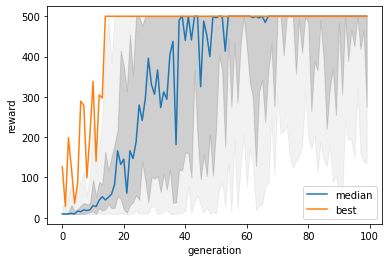

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 913 (seed=908972, Thu Nov 25 00:24:16 2021)


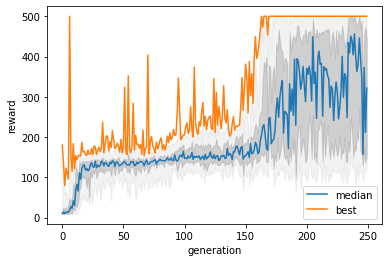

In [7]:
env = gym.make('CartPole-v1')

fc_nn = FCNNet().eval()
fc_nn_params, fc_nn_history = fit_model(
    fc_nn, env,
    n_generations=100
)
set_params(fc_nn, fc_nn_params)
plot_evolution(fc_nn_history)


class ExtraFeatures:
    def __init__(self, n):
        self.n = n
        self.perm = np.random.permutation(4 + n)
        
    def __call__(self, x, iteration):
        return np.concatenate([x, np.random.normal(0, 0.1, size=(self.n, ))])[self.perm]


attention_neuron = AttentionNeuron().eval()
attention_neuron_params, attention_neuron_history = fit_model(
    attention_neuron,
    env,
    # Lots more steps required to converge
    n_generations=250,
    obs_transform=ExtraFeatures(10)
)
set_params(attention_neuron, attention_neuron_params)
plot_evolution(attention_neuron_history)

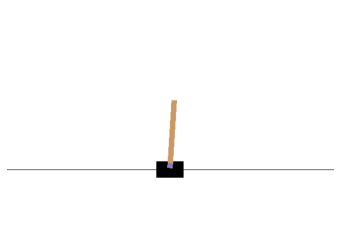

500.0

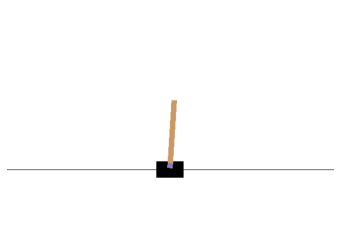

In [8]:
env = gym.make('CartPole-v1')
one_fitness(attention_neuron, gnwrapper.Animation(env))

In [9]:
average_fitness(attention_neuron, env)

500.0

In [10]:
# Check that the model is more invariant to permutations that a fully connected neural network
results = []
for model, model_label in [(fc_nn, "FCNN"), (attention_neuron, "AttentionNeuron")]:
    for perm, perm_label in [
        (np.array([0, 1, 2, 3]), False),
        (np.array([2, 0, 3, 1]), True)
    ]:
        # Run each trial a bunch of times
        for _ in range(100):
            fitness = one_fitness(model, env, obs_transform=lambda x, _: x[perm])
            results.append({"model": model_label, "permuted": perm_label, "fitness": fitness})

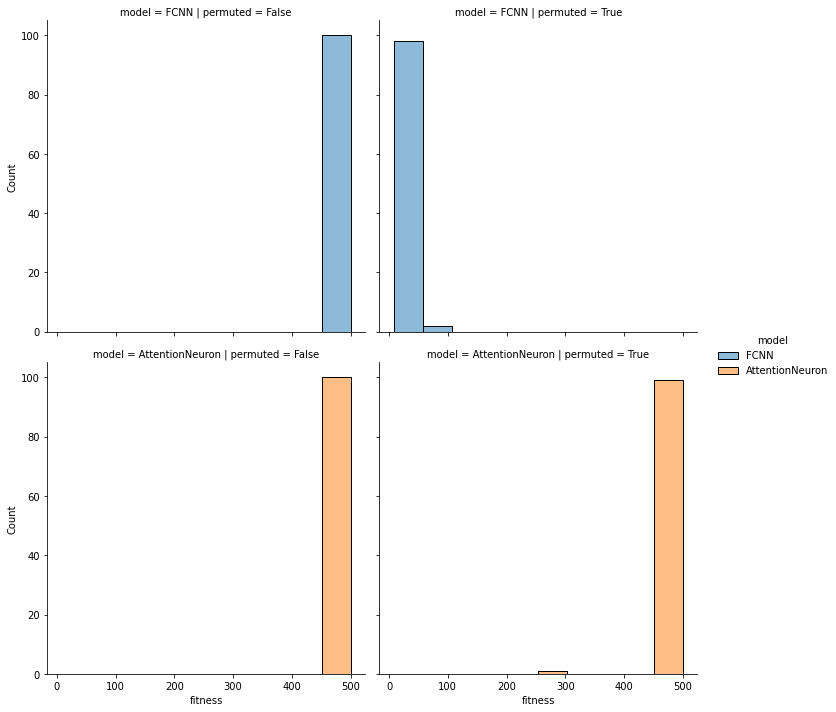

In [11]:
df = pd.DataFrame(results)
sns.displot(data=df, x="fitness", row="model", col="permuted", hue="model")

In [12]:
class Permuter:
    def __init__(self, every):
        self.every = every
        self.perm = np.arange(4)

    def __call__(self, x, iteration):
        if iteration % self.every == 0 and iteration != 0:
            self.perm = np.random.permutation(4)
        return x[self.perm]


results = []
for model, model_label in [(fc_nn, "FCNN"), (attention_neuron, "AttentionNeuron")]:
    for permute_every in [500, 200, 100, 50, 25]:
        
        # Run each trial a bunch of times
        for _ in range(50):
            fitness = one_fitness(model, env, obs_transform=Permuter(permute_every))
            results.append({"model": model_label, "permute_every": permute_every, "fitness": fitness})
    

<AxesSubplot:xlabel='permute_every', ylabel='fitness'>

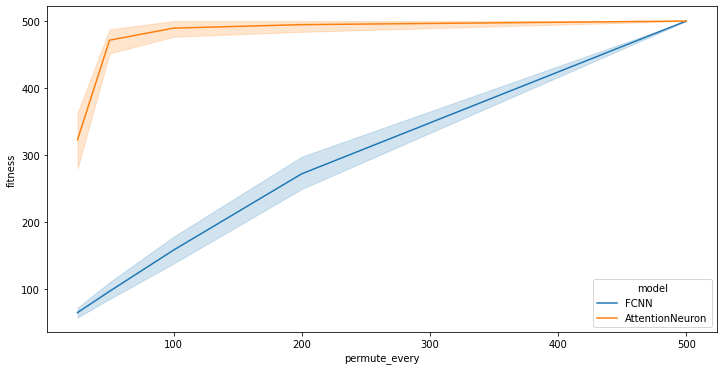

In [13]:
df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, y="fitness", x="permute_every", hue="model")

In [14]:
class ExtraFeatures:
    def __init__(self, n):
        self.n = n
        self.perm = np.random.permutation(4 + n)
        
    def __call__(self, x, iteration):
        return np.concatenate([x, np.random.normal(0, 0.01, size=(self.n, ))])[self.perm]


results = []
for model, model_label in [(attention_neuron, "AttentionNeuron")]:
    for extra_features in [0, 1, 5, 10]:
        
        # Run each trial a bunch of times
        for _ in range(50):
            fitness = one_fitness(model, env, obs_transform=ExtraFeatures(extra_features))
            results.append({"model": model_label, "extra_features": extra_features, "fitness": fitness})


<AxesSubplot:xlabel='extra_features', ylabel='fitness'>

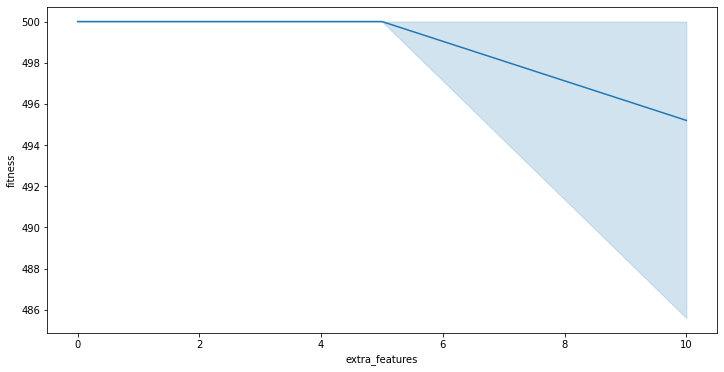

In [15]:
df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, y="fitness", x="extra_features")